### 1st Virtual Methods Seminar: Methods of Computational Social Science
## Introduction to Social Network Science with Python
# Network Construction & Visualization (Demo)
Instructors: Haiko Lietz & Olga Zagovora

Date: September 23, 2020

<div class="alert alert-info">
<big><b>Comment</b></big>

In the beginning of the notebook it may seem that it is a hassle to construct and visualize graphs in networkx. But stick to the end. We will provide functions that easy things.
</div>

## Packages

In [1]:
import sys
libs_path = '../libs/'
sys.path.append(libs_path)
import compsoc as cs

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

## Graph construction and visualization: Multiplex ties in Renaissance Florence
An ordinary **graph** contains nodes from just one set. Edges are drawn among the nodes of this set. Our example graph consists of multiplex ties among elite families in Renaissance Florence. This is the dataset used in the introductory lecture. But we are not using the collection that networkx provides, but one that is copied directly from the [original paper](https://doi.org/10.1086/230190) by Padgett & Ansell (1993). We can load the collection by calling a function that is privided by [`compsoc` – *Notebooks for Computational Sociology*](https://github.com/gesiscss/compsoc), a service under development at GESIS. The `elite_families_collection()` function writes four dataframes:

In [3]:
families, parties, relations, domains = cs.elite_families_collection(path='../../data/elite_families/')

The goal of this notebook is to visualize information via graph properties. We use families as nodes. The `families` table is a **node list**. It contains the node identifiers used for network construction (`family_id`) and the family name used for labeling nodes (`family`). Each node represents a block of $n$ families, so this column gives the name of a representative family. `block_size` is the number of families that are represented by the respective identifier. `party_id` will be visualized as a **node shape**. Gross wealth will be visualized as **node size**. It is averaged over all block members (`gross_wealth_mean`). The data of the first prior, also averaged for all block members (`date_of_first_prior_mean`), was a Florentine measure of family status. It has been transformed into a `status_color` which will be used as the **node border color**. Finally, the three `numbers_active_...` columns tell how many persons in a block were loyal to the `...medici`, loyal to the `...oligarchs` or remained `...neutral`. This information has been transformed into a `partisanship_color` to be used as the **node_color**:

In [4]:
families.head()

,family_id,family,party_id,gross_wealth_mean,date_of_first_prior_mean,block_size,numbers_active_medici,numbers_active_oligarch,numbers_active_neutral,pos_x,pos_y,partisanship_color,status_color
0,0,MEDICI,0,82702,1318,3,7,0,0,-0.0776,0.0391,#387db8,#b6b6b6
1,1,TORNABUONI,0,42840,1303,7,8,1,1,0.0776,0.1251,#5c82b0,#d4d4d4
2,2,GUICCIARDINI,0,40617,1289,5,6,0,0,-0.1761,-0.0705,#387db8,#f1f1f1
3,3,GINORI,0,21167,1344,2,11,0,0,-0.2381,0.1034,#387db8,#818181
4,4,DIETISALVI,0,13137,1340,2,3,0,0,-0.4000,0.1282,#387db8,#898989


The `relations` table is an **edge list**. We will use it to create a weighted directed multigraph (MultiDiGraph). `weight` will be used for **edge width** and the `domain_id` will be visualized as an **edge color**:

In [5]:
relations.head()

,family_id_from,family_id_to,weight,domain_id
0,0,1,1,0
1,0,23,1,0
2,2,0,1,0
3,3,4,1,0
4,5,3,1,0


The `domains` table tells which network layer contains which type of tie:

In [6]:
domains.head()

,domain_id,domain
0,0,Marriage
1,1,Economic
2,2,Political
3,3,Friendship


### Starting simple: Friendship relations
Graph construction and visualization is a piece-by-piece process, particularly if there are many node and edge attributes. Let's start with a simple undirected unweighted graph: friendship. The direction of the edges can be seen in the data (e.g., 0 → 2 and 2 → 0), but if we constrct a `nx.Graph()`, that information will be discarded:

In [7]:
friendship = relations[relations['domain_id'] == 3][['family_id_from', 'family_id_to']]
friendship.head()

,family_id_from,family_id_to
75,0,2
76,0,23
77,2,0
78,2,20
79,12,16


The `add_nodes_from()` and `add_edges_from()` functions can handle dataframes as inputs when only the values are used:

In [8]:
G_friendship = nx.Graph()
#G_friendship.add_nodes_from(families['family_id'].values) # uncomment this to have all families in the graph
G_friendship.add_edges_from(friendship.values)

In [9]:
print(nx.info(G_friendship))

Name: 
Type: Graph
Number of nodes: 8
Number of edges: 7
Average degree:   1.7500


Then draw:

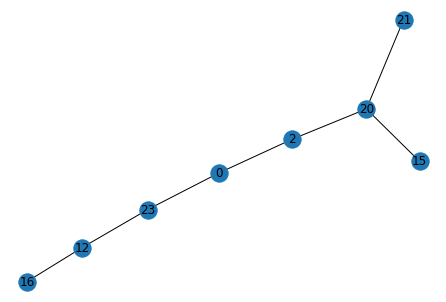

In [10]:
#plt.figure(figsize=(8, 8))
nx.draw(G_friendship, with_labels=True)

The density (realized fraction of all possible ties) of the graph is:

In [11]:
nx.density(G_friendship)

0.25

### Building the MultiDiGraph using standard networkx
#### Graph construction
Now we want to create the MultiDiGraph. Call `add_nodes_from()` so they are stored in order and not by arrival:

In [12]:
G = nx.MultiDiGraph()
G.add_nodes_from(families['family_id'].values)

Besides the edge `weight`s we also want to assign a color to the edges based on the `domain_id`. Get the respective color from the `domain_color` dictionary (if you're looking for a source of colors, [colorbrewer2.org](https://colorbrewer2.org/) is just what you need):

In [13]:
domain_color = {0: '#984ea3', 1: '#ff7f00', 2: '#4daf4a', 3: '#a65628'}

Recall that the purpose of a dictionary is to obtain the value of a key when you have the key. The color of domain 0 shall be:

In [14]:
domain_color[3]

'#a65628'

To add edges, columns must be a [4-tuple (u, v, k, d)](https://networkx.github.io/documentation/networkx-2.4/reference/classes/generated/networkx.MultiDiGraph.add_edges_from.html) for an edge with key and data, i.e., `domain_id` must be the third column and the attributesfor `weight` and the desired edge color must be in a dictionary:

In [15]:
edge_list = relations.copy()
edge_list.loc[:, 'color'] = [domain_color[identifier] for identifier in edge_list['domain_id'].values]
edge_list.loc[:, 'dict'] = edge_list[['weight', 'color']].to_dict(orient='records')
edge_list = edge_list[['family_id_from', 'family_id_to', 'domain_id', 'dict']]

In [16]:
edge_list.head()

,family_id_from,family_id_to,domain_id,dict
0,0,1,0,"{'weight': 1, 'color': '#984ea3'}"
1,0,23,0,"{'weight': 1, 'color': '#984ea3'}"
2,2,0,0,"{'weight': 1, 'color': '#984ea3'}"
3,3,4,0,"{'weight': 1, 'color': '#984ea3'}"
4,5,3,0,"{'weight': 1, 'color': '#984ea3'}"


Now we can simply `add_edges_from()` that dataframe:

In [17]:
G.add_edges_from(edge_list.values)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [18]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 33
Number of edges: 86
Average in degree:   2.6061
Average out degree:   2.6061


Check if the layer keys and edge attributes have been internalized correctly:

In [19]:
G.edges(data=True, keys=True)

OutMultiEdgeDataView([(0, 1, 0, {'weight': 1, 'color': '#984ea3'}), (0, 1, 2, {'weight': 1, 'color': '#4daf4a'}), (0, 23, 0, {'weight': 1, 'color': '#984ea3'}), (0, 23, 2, {'weight': 1, 'color': '#4daf4a'}), (0, 23, 3, {'weight': 1, 'color': '#a65628'}), (0, 3, 1, {'weight': 3, 'color': '#ff7f00'}), (0, 3, 2, {'weight': 1, 'color': '#4daf4a'}), (0, 8, 1, {'weight': 1, 'color': '#ff7f00'}), (0, 8, 2, {'weight': 1, 'color': '#4daf4a'}), (0, 12, 1, {'weight': 2, 'color': '#ff7f00'}), (0, 12, 2, {'weight': 2, 'color': '#4daf4a'}), (0, 2, 2, {'weight': 1, 'color': '#4daf4a'}), (0, 2, 3, {'weight': 1, 'color': '#a65628'}), (0, 6, 2, {'weight': 1, 'color': '#4daf4a'}), (0, 13, 2, {'weight': 1, 'color': '#4daf4a'}), (1, 26, 1, {'weight': 1, 'color': '#ff7f00'}), (1, 32, 2, {'weight': 1, 'color': '#4daf4a'}), (2, 0, 0, {'weight': 1, 'color': '#984ea3'}), (2, 0, 3, {'weight': 1, 'color': '#a65628'}), (2, 19, 1, {'weight': 1, 'color': '#ff7f00'}), (2, 29, 1, {'weight': 1, 'color': '#ff7f00'}), (2

#### Graph drawing: Edge attributes
Now we want to use the `weight` and `domain` attributes for graph drawing. Edge parameters require iterables (e.g., lists) as inputs. This is the input networkx wants for the **width** parameter:

In [20]:
list(nx.get_edge_attributes(G, 'weight').values())[:20]

[1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]

The `edge_attribute_to_list()` function is nicer:

In [21]:
cs.edge_attribute_to_list(G, 'weight')[:20]

[1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Now we create the edge property (ep) lists:

In [22]:
ep_width = cs.edge_attribute_to_list(G, 'weight')
ep_edge_color = cs.edge_attribute_to_list(G, 'color')

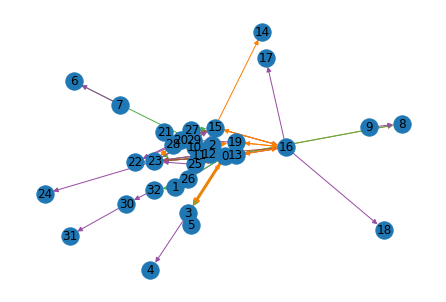

In [23]:
#plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, width=ep_width, edge_color=ep_edge_color)

#### Graph layouting
The graph layout is not convincing. networkx offers a few [node positioning algorithms for graph drawing](https://networkx.github.io/documentation/networkx-2.4/reference/drawing.html#module-networkx.drawing.layout). In the lecture, we discussed two standard algorithms. Per default, `draw()` uses the [Fruchterman-Reingold force-directed algorithm](https://networkx.github.io/documentation/networkx-2.4/reference/generated/networkx.drawing.layout.spring_layout.html#networkx.drawing.layout.spring_layout) with a maximum number of 50 iterations taken. For graphs as small as this one, `iterations=50` is clearly sufficient. For larger networks, more iterations are needed. Parameter `k`, the optimal distance between nodes, is also influential. Experiment with a few layouts and store them in a vertex property (vp) variable:

In [24]:
vp_pos = nx.spring_layout(G, iterations=20, seed=0) # setting a random seed creates reproducible results

In [25]:
vp_pos = nx.kamada_kawai_layout(G) # chose this one

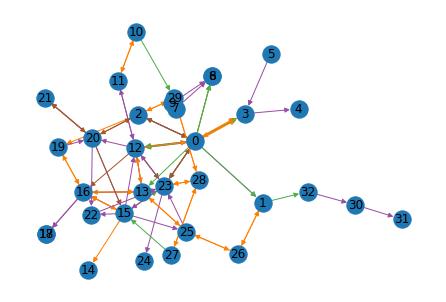

In [26]:
#plt.figure(figsize=(8, 8))
nx.draw(G, with_labels=True, width=ep_width, edge_color=ep_edge_color, pos=vp_pos)

#### Graph drawing: Node attributes
Now let's take care of the nodes. We want to use `gross_wealth_mean` for **node size** and `partisanship_color` for **node color**:

In [27]:
families.head()

,family_id,family,party_id,gross_wealth_mean,date_of_first_prior_mean,block_size,numbers_active_medici,numbers_active_oligarch,numbers_active_neutral,pos_x,pos_y,partisanship_color,status_color
0,0,MEDICI,0,82702,1318,3,7,0,0,-0.0776,0.0391,#387db8,#b6b6b6
1,1,TORNABUONI,0,42840,1303,7,8,1,1,0.0776,0.1251,#5c82b0,#d4d4d4
2,2,GUICCIARDINI,0,40617,1289,5,6,0,0,-0.1761,-0.0705,#387db8,#f1f1f1
3,3,GINORI,0,21167,1344,2,11,0,0,-0.2381,0.1034,#387db8,#818181
4,4,DIETISALVI,0,13137,1340,2,3,0,0,-0.4000,0.1282,#387db8,#898989


Loop through the nodes of our graph `G`, add the two attributes, and assign them the respective values from the dataframe:

In [28]:
for identifier in families['family_id']:
    G.nodes[identifier]['wealth'] = families['gross_wealth_mean'][identifier]
    G.nodes[identifier]['partisanship'] = families['partisanship_color'][identifier]

In [29]:
G.nodes(data=True)

NodeDataView({0: {'wealth': 82702, 'partisanship': '#387db8'}, 1: {'wealth': 42840, 'partisanship': '#5c82b0'}, 2: {'wealth': 40617, 'partisanship': '#387db8'}, 3: {'wealth': 21167, 'partisanship': '#387db8'}, 4: {'wealth': 13137, 'partisanship': '#387db8'}, 5: {'wealth': 18957, 'partisanship': '#8c4c6b'}, 6: {'wealth': 8158, 'partisanship': '#387db8'}, 7: {'wealth': 19887, 'partisanship': '#387db8'}, 8: {'wealth': 12420, 'partisanship': '#387db8'}, 9: {'wealth': 18921, 'partisanship': '#387db8'}, 10: {'wealth': 48364, 'partisanship': '#ab3b4f'}, 11: {'wealth': 48066, 'partisanship': '#f28c8c'}, 12: {'wealth': 85300, 'partisanship': '#a63d54'}, 13: {'wealth': 14529, 'partisanship': '#e84042'}, 14: {'wealth': 5403, 'partisanship': '#e31a1c'}, 15: {'wealth': 50125, 'partisanship': '#e62e30'}, 16: {'wealth': 37118, 'partisanship': '#e83b3d'}, 17: {'wealth': 14367, 'partisanship': '#ed6669'}, 18: {'wealth': 19640, 'partisanship': '#ed6669'}, 19: {'wealth': 13047, 'partisanship': '#ed6669'}

The node attributes have been internalized in the graph. To use them, they must be assigned to the `node_size` and `node_color` parameters of networkx's `draw()` function as lists. The helper function `node_attribute_to_list()` does just that:

In [30]:
vp_node_size = cs.node_attribute_to_list(G, 'wealth')
vp_node_color = cs.node_attribute_to_list(G, 'partisanship')

When drawing the graph, size attributes often need a transformation for the information to be readable. We can use list comprehension for this purpose:

In [31]:
factor = .025
vp_node_size = [node_size*factor for node_size in vp_node_size]

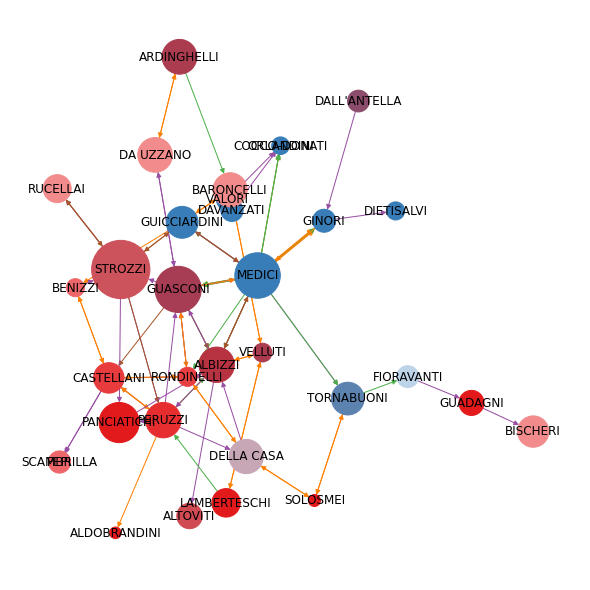

In [32]:
plt.figure(figsize=(8, 8))
nx.draw(
    G, 
    width=ep_width, 
    edge_color=ep_edge_color, 
    pos=vp_pos, 
    node_size=vp_node_size, 
    node_color=vp_node_color, 
    labels=families['family']
)

This already looks pretty good. Note that we can simply assign a dataframe column to a node, such as `labels=families['family']`. Besides graph structure, we're communicating four attributes: Families loyal with the oligarchs (reddish colored nodes) tend to be wealthy and cohesive; families loyal with the Medici (bleish colored nodes) tend to be less wealthy (except for the Medici family itself, node 0) and less cohesive.

However, as stated above and as shown in the lecture, we'd like 

- to encode party affiliation as node shapes, 
- to draw curved edges so they don't hide each other, and
- to size labels according to some attribute.

Labeling nodes by family names can be done easily. As you saw yesterday, networkx can handle unnormalized node and edge lists of strings. `draw(with_labels=True)` will plot node labels if they are strings. But our data is in the so-called "normal form", i.e., the are only identifiers in the edge list and the node label is in the node list. Data normalization is done for good reasons. Fortunately, there is a way out.
#### Drawing nodes, edges, and labels separately
`draw()` is a so-called wrapper which basically calls up the three methods [draw_networkx_nodes()](https://networkx.github.io/documentation/networkx-2.4/reference/generated/networkx.drawing.nx_pylab.draw_networkx_nodes.html?highlight=draw_networkx_nodes#networkx.drawing.nx_pylab.draw_networkx_nodes), [draw_networkx_edges()](https://networkx.github.io/documentation/networkx-2.4/reference/generated/networkx.drawing.nx_pylab.draw_networkx_edges.html?highlight=draw_networkx_edges#networkx.drawing.nx_pylab.draw_networkx_edges), and [draw_networkx_labels()](https://networkx.github.io/documentation/networkx-2.4/reference/generated/networkx.drawing.nx_pylab.draw_networkx_labels.html?highlight=draw_networkx_labels#networkx.drawing.nx_pylab.draw_networkx_labels). Those give us all the fexibility we need to achieve our goals:

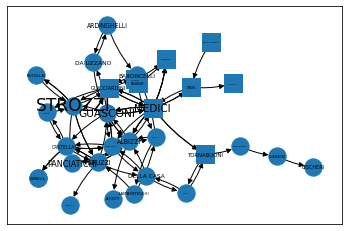

In [33]:
# encode party affiliation as node shapes
shapes = {0: 's', 1: 'o'}

for identifier in set(families['party_id']):
    df = families[families['party_id'] == identifier]
    nodes = df['family_id'].tolist()
    
    nx.draw_networkx_nodes(
        G, 
        pos=vp_pos, 
        nodelist=nodes, 
        node_shape=shapes[identifier]
    )

# draw curved edges
nx.draw_networkx_edges(
    G, 
    pos=vp_pos, 
    connectionstyle='arc3, rad=.1'
)

# size labels according to some attribute
vp_font_size = [node_size/200 for node_size in vp_node_size]
for node in G.nodes():
    nx.draw_networkx_labels(
        G, 
        pos=vp_pos, 
        labels={node: families['family'][node]}, 
        font_size=vp_font_size[node]
    )

### Building the MultiDiGraph using `compsoc`
You see that many things are possible with networkx, also regarding graph drawing. However, constructing graphs and plotting them nicely requires many lines of code. The `compsoc` toolkit contains two functions to handle digital behavioral data and network data. `construct_graph()` builds networks from data in the normal form. It basically takes a node list and an edge list and lets the user specify **default attributes** for node position, node size, node color, etc. `draw_graph()` visualizes networks. `draw_graph()` uses these attributes by default but lets the user not use them or specify other ones. Both functions work in tandem. We will be using them repeatedly.

In `construct_graph()`, since the elite families graph is supposed to be a MultiDiGraph, set `directed=True` and `multiplex=True`. Assign node and edge lists as above. Node lists must be dataframes in the normal form, i.e., the identifier must be an integer from 0 to $N-1$ for a graph of $N$ nodes. Edge lists must be dataframes that use these identifiers in the first two columns. The third column must contain an edge weight. If `multiplex=True`, the fourth column must be an integer from 0 to $m-1$ for $m$ network layers. All parameters `node_...` expect as input a column name of the node list. `layer_color` is a dictionary of colors for edge layers. Below we override the default dictionary by custom colors:

In [34]:
H = cs.construct_graph(
    directed=True, 
    multiplex=True, 
    graph_name='elite_families', 
    node_list=families, 
    edge_list=relations, 
    node_pos=['pos_x', 'pos_y'], 
    node_size='gross_wealth_mean', 
    node_color='partisanship_color', 
    node_shape='party_id', 
    node_border_color='status_color', 
    node_label='family', 
    layer_color={0: '#984ea3', 1: '#ff7f00', 2: '#4daf4a', 3: '#a65628'}
)

In [35]:
print(nx.info(H))

Name: elite_families
Type: MultiDiGraph
Number of nodes: 33
Number of edges: 86
Average in degree:   2.6061
Average out degree:   2.6061


In `draw_graph()`, it is not necessary to specify which attributes to use because the ones we specified in `construct_graph()` will be used by default. We do need to set all parameters that deviate from the default values. These are typically size factors. In this case we also want node borders to be thicker and edges to be curved. `labels='text'` means that we want nodes to be labeled by family names, not identifiers:

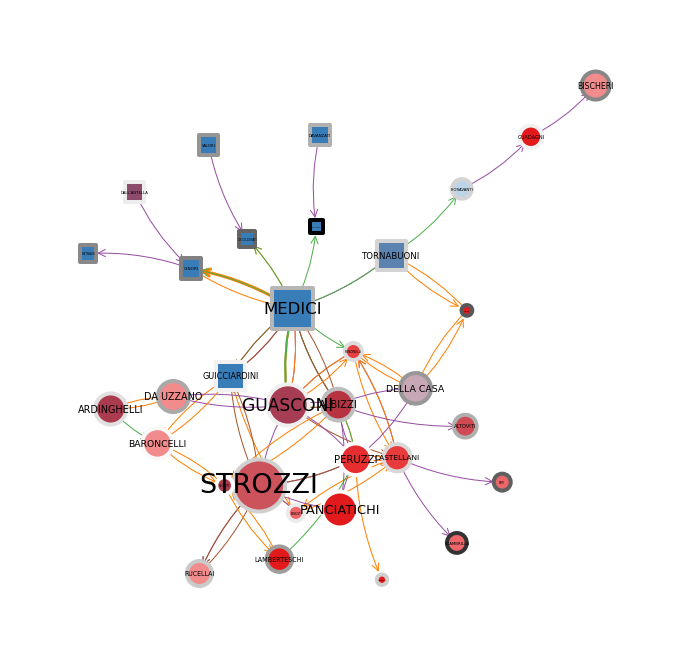

In [36]:
cs.draw_graph(
    H, 
    node_size_factor=0.02, 
    node_border_width=4, 
    curved_edges=True, 
    font_size_factor=.0002, 
    labels='text'
)

<div class="alert alert-info">
<big><b>Comment</b></big>

Directed edges terminate somewhere in the air and parallel curved edges lie on top of each other. This is not a problem with networkx but with the `draw_graph()` function. These features are not yet implemented.
</div>

To draw a small DiGraph version without any attributes, set attributes to None and use a `uniform_vertex_property()` for node color:

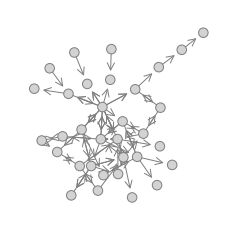

In [37]:
cs.draw_graph(
    H, 
    node_size=None, 
    node_size_factor=.1, 
    node_color=cs.uniform_vertex_property(H, 'lightgray'), 
    node_shape=None, 
    node_border_color=None, 
    node_border_width=1, 
    edge_width=None, 
    edge_color=None, 
    figsize='small'
)

## Bipartite graph construction and projection: Meeting via social events
A **bipartite graph** contains nodes from two sets. Edges are only allowed among two nodes belonging to different sets. The collection we now work with is another classic in Social Network Analysis: "This is a data set of 18 women observed over a nine-month period. During that period, various subsets of these women met in a series of 14 informal social events. The data recored which women met for which events." ([Source](https://networkdata.ics.uci.edu/netdata/html/davis.html))

The **two modes** (sets) of nodes are social events and persons. As network analysts we often have such data. Digital behavioral data, in particular, is event data where the units of analysis are not aggregate social events but communicative micro events (transactions).

In [38]:
I = nx.davis_southern_women_graph()

In [39]:
print(nx.info(I))

Name: 
Type: Graph
Number of nodes: 32
Number of edges: 89
Average degree:   5.5625


In [40]:
I.nodes(data=True)

NodeDataView({'Evelyn Jefferson': {'bipartite': 0}, 'Laura Mandeville': {'bipartite': 0}, 'Theresa Anderson': {'bipartite': 0}, 'Brenda Rogers': {'bipartite': 0}, 'Charlotte McDowd': {'bipartite': 0}, 'Frances Anderson': {'bipartite': 0}, 'Eleanor Nye': {'bipartite': 0}, 'Pearl Oglethorpe': {'bipartite': 0}, 'Ruth DeSand': {'bipartite': 0}, 'Verne Sanderson': {'bipartite': 0}, 'Myra Liddel': {'bipartite': 0}, 'Katherina Rogers': {'bipartite': 0}, 'Sylvia Avondale': {'bipartite': 0}, 'Nora Fayette': {'bipartite': 0}, 'Helen Lloyd': {'bipartite': 0}, 'Dorothy Murchison': {'bipartite': 0}, 'Olivia Carleton': {'bipartite': 0}, 'Flora Price': {'bipartite': 0}, 'E1': {'bipartite': 1}, 'E2': {'bipartite': 1}, 'E3': {'bipartite': 1}, 'E4': {'bipartite': 1}, 'E5': {'bipartite': 1}, 'E6': {'bipartite': 1}, 'E7': {'bipartite': 1}, 'E8': {'bipartite': 1}, 'E9': {'bipartite': 1}, 'E10': {'bipartite': 1}, 'E11': {'bipartite': 1}, 'E12': {'bipartite': 1}, 'E13': {'bipartite': 1}, 'E14': {'bipartite':

In [41]:
I.edges(data=True)

EdgeDataView([('Evelyn Jefferson', 'E1', {}), ('Evelyn Jefferson', 'E2', {}), ('Evelyn Jefferson', 'E3', {}), ('Evelyn Jefferson', 'E4', {}), ('Evelyn Jefferson', 'E5', {}), ('Evelyn Jefferson', 'E6', {}), ('Evelyn Jefferson', 'E8', {}), ('Evelyn Jefferson', 'E9', {}), ('Laura Mandeville', 'E1', {}), ('Laura Mandeville', 'E2', {}), ('Laura Mandeville', 'E3', {}), ('Laura Mandeville', 'E5', {}), ('Laura Mandeville', 'E6', {}), ('Laura Mandeville', 'E7', {}), ('Laura Mandeville', 'E8', {}), ('Theresa Anderson', 'E2', {}), ('Theresa Anderson', 'E3', {}), ('Theresa Anderson', 'E4', {}), ('Theresa Anderson', 'E5', {}), ('Theresa Anderson', 'E6', {}), ('Theresa Anderson', 'E7', {}), ('Theresa Anderson', 'E8', {}), ('Theresa Anderson', 'E9', {}), ('Brenda Rogers', 'E1', {}), ('Brenda Rogers', 'E3', {}), ('Brenda Rogers', 'E4', {}), ('Brenda Rogers', 'E5', {}), ('Brenda Rogers', 'E6', {}), ('Brenda Rogers', 'E7', {}), ('Brenda Rogers', 'E8', {}), ('Charlotte McDowd', 'E3', {}), ('Charlotte McD

Check if persons are only connected to events:

In [42]:
nx.is_bipartite(I)

True

Using the `draw()` function from networks, set the mode of the nodes as color:

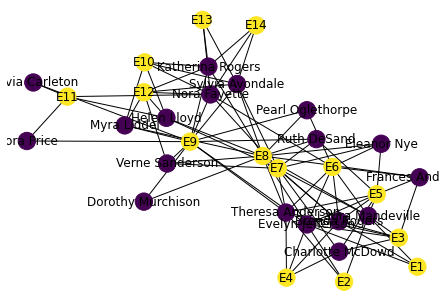

In [43]:
nx.draw(I, with_labels=True, node_color=cs.node_attribute_to_list(I, 'bipartite'))

Analyzing bipartite networks can be a powerful exercise. networkx provides [functions and operations for bipartite graphs](https://networkx.github.io/documentation/networkx-2.4/reference/algorithms/bipartite.html?highlight=bipartite#module-networkx.algorithms.bipartite) but we do not cover this here. Instead we study the **projections** that bipartite (2-mode) graphs can be transformed to: the projected graph of **events**, where the edges tell how many persons they have in common, and the projected graph of **persons**, where edges tell how many events they have in common. To do this, we must know the nodes of each mode. This information is in the `'bipartite'` node attribute:

In [44]:
modes = nx.get_node_attributes(I, 'bipartite')

Use list comprehension to obtain the two lists of nodes from the `modes` dictionary:

In [45]:
nodes_events = [node for node, mode in modes.items() if mode == 1]
print(nodes_events)
nodes_persons = [node for node, mode in modes.items() if mode == 0]
print(nodes_persons)

['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11', 'E12', 'E13', 'E14']
['Evelyn Jefferson', 'Laura Mandeville', 'Theresa Anderson', 'Brenda Rogers', 'Charlotte McDowd', 'Frances Anderson', 'Eleanor Nye', 'Pearl Oglethorpe', 'Ruth DeSand', 'Verne Sanderson', 'Myra Liddel', 'Katherina Rogers', 'Sylvia Avondale', 'Nora Fayette', 'Helen Lloyd', 'Dorothy Murchison', 'Olivia Carleton', 'Flora Price']


Alternatively, we can get the lists of nodes from the graph itself:

In [46]:
#nodes_events = list(nx.bipartite.sets(I)[1])
#print(nodes_events)
#nodes_persons = list(nx.bipartite.sets(I)[0])
#print(nodes_persons)

### Projection using standard networkx
#### Projection to the event mode
To get the graph of events, where the edges tell how many persons they have in common, call the `weighted_projected_graph()` [function](https://networkx.github.io/documentation/networkx-2.4/reference/algorithms/generated/networkx.algorithms.bipartite.projection.weighted_projected_graph.html?highlight=weighted_projected_graph#networkx.algorithms.bipartite.projection.weighted_projected_graph):

In [47]:
I_events = nx.bipartite.weighted_projected_graph(I, nodes_events)

In [48]:
pos_events = nx.spring_layout(I_events)

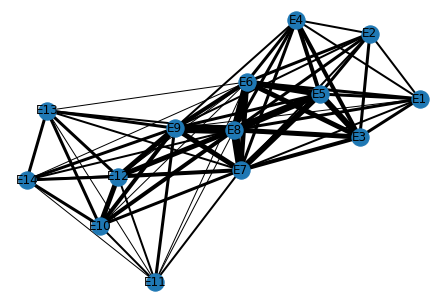

In [49]:
nx.draw(
    I_events, 
    with_labels=True, 
    pos=pos_events, 
    width=cs.edge_attribute_to_list(I_events, 'weight')
)

We can also get, e.g., the similarity of events (fraction of all persons that participated in two events) by calling the `overlap_weighted_projected_graph()` [function](https://networkx.github.io/documentation/networkx-2.4/reference/algorithms/generated/networkx.algorithms.bipartite.projection.overlap_weighted_projected_graph.html#networkx.algorithms.bipartite.projection.overlap_weighted_projected_graph):

In [50]:
I_events_jaccard = nx.bipartite.overlap_weighted_projected_graph(I, nodes_events)

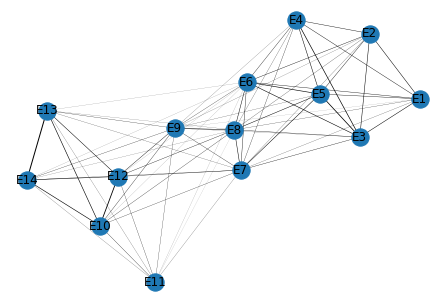

In [51]:
nx.draw(
    I_events_jaccard, 
    with_labels=True, 
    pos=pos_events, 
    width=cs.edge_attribute_to_list(I_events_jaccard, 'weight')
)

#### Projection to the person mode
To get the graph of persons, where edges tell how many events they have in common:

In [52]:
I_persons = nx.bipartite.weighted_projected_graph(I, nodes_persons)

In [53]:
pos_persons = nx.spring_layout(I_persons)

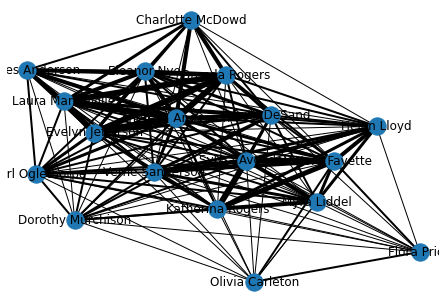

In [54]:
nx.draw(
    I_persons, 
    with_labels=True, 
    pos=pos_persons, 
    width=cs.edge_attribute_to_list(I_persons, 'weight')
)

We can also get, e.g., a normalized version of this graph (larger events create smaller co-participations) by calling the `collaboration_weighted_projected_graph()` [function](https://networkx.github.io/documentation/networkx-2.4/reference/algorithms/generated/networkx.algorithms.bipartite.projection.collaboration_weighted_projected_graph.html#networkx.algorithms.bipartite.projection.collaboration_weighted_projected_graph):

In [55]:
I_persons_newman = nx.bipartite.collaboration_weighted_projected_graph(I, nodes_persons)

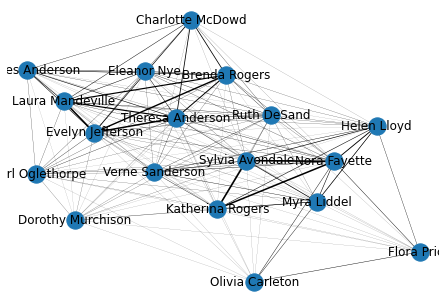

In [56]:
nx.draw(
    I_persons_newman, 
    with_labels=True, 
    pos=pos_persons, 
    width=cs.edge_attribute_to_list(I_persons_newman, 'weight')
)

### Projection using `compsoc`
The `compsoc` toolkit contains the `project_selection_matrix()` function to make these projections, including obtaining simiarity or size normalized edge weights. It is explained in detail in the [meaning_structures](https://github.com/gesiscss/compsoc/blob/master/meaning_structures.ipynb) notebook of the `compsoc` toolkit. To apply the function, the southern women dataset must be in the standard form:

In [57]:
davis_southern_women_graph = pd.DataFrame(nx.to_edgelist(I), columns=['person', 'event', 'empty_attribute'])
davis_southern_women_graph.drop(columns=['empty_attribute'], inplace=True)
davis_southern_women_graph.head()

,person,event
0,Evelyn Jefferson,E1
1,Evelyn Jefferson,E2
2,Evelyn Jefferson,E3
3,Evelyn Jefferson,E4
4,Evelyn Jefferson,E5


To obtain identifiers for names, the trick is to make the `event` and `person` columns so-called [categoricals](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html):

In [58]:
events_category = pd.Series(davis_southern_women_graph['event'], dtype='category')
persons_category = pd.Series(davis_southern_women_graph['person'], dtype='category')

We can then use the codes of the categoricals as identifiers to construct the `selections` of events by persons (stored in the selection matrix). `event_id` is the first column by intention because it corresponds to the transactions (the unit of analysis in the unified data model) that persons chose to participate in:

In [59]:
participations = pd.concat([events_category.cat.codes, persons_category.cat.codes], axis=1)
participations['weight'] = 1
participations.columns = ['event_id', 'person_id', 'weight']
participations.head()

,event_id,person_id,weight
0,0,4,1
1,6,4,1
2,7,4,1
3,8,4,1
4,9,4,1


The entity tables are:

In [60]:
events = pd.DataFrame(events_category.cat.categories, columns=['event'])
events['event_id'] = events.index
events = events[['event_id', 'event']]
events.head()

,event_id,event
0,0,E1
1,1,E10
2,2,E11
3,3,E12
4,4,E13


In [61]:
persons = pd.DataFrame(persons_category.cat.categories, columns=['person'])
persons['person_id'] = persons.index
persons = persons[['person_id', 'person']]
persons.head()

,person_id,person
0,0,Brenda Rogers
1,1,Charlotte McDowd
2,2,Dorothy Murchison
3,3,Eleanor Nye
4,4,Evelyn Jefferson


#### Projection to the event mode
The `project_selection_matrix()` function needs as input a `selection` dataframe, here: of events participated by persons, and `how` the projection should be made. Projecting to the event mode means `how='transactions`. Two additional parameters are not used so default values will be used: `remove_loops=True` means that similarities of events with themselves will be removed; `symmetrize=True` means that redundant information in the matrix will be removed, practically rendering the matrix an undirected one.
##### Not using normalization

In [62]:
similarities, event_attributes = cs.project_selection_matrix(
    selections=participations, 
    how='transactions', 
    transaction_id='event_id', 
    fact_id='person_id', 
    norm=False
)

Two dataframes are created. `similarities['similarity']` tells how many persons participated in both events:

In [63]:
similarities.head()

,event_id_from,event_id_to,similarity
0,0,6,2
1,0,7,3
2,0,8,2
3,0,9,3
4,0,10,3


In the `event_attributes` dataframe, `degree` tells how many events overlapped with an event in at least one person; `weight` tells how many persons attended an event:

In [64]:
event_attributes.head()

,event_id,degree,weight
0,0,8,3
1,6,8,3
2,7,8,6
3,8,8,4
4,9,8,8


In [65]:
J_events = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='J_events', 
    node_list=event_attributes, 
    edge_list=similarities
)

In [66]:
vp_node_pos_events = nx.spring_layout(J_events)

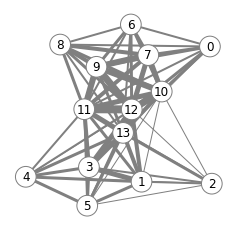

In [67]:
cs.draw_graph(
    J_events, 
    node_pos=vp_node_pos_events, 
    node_size_factor=.2, 
    labels='id', 
    figsize='small'
)

##### Using normalization

In [68]:
similarities_norm, event_attributes_norm = cs.project_selection_matrix(
    selections=participations, 
    how='transactions', 
    transaction_id='event_id', 
    fact_id='person_id', 
    norm=True
)

`similarities_norm['similarity']` results from the normalization and is a similarity score between 0 and 1:

In [69]:
similarities_norm.head()

,event_id_from,event_id_to,similarity
0,0,6,0.222222
1,0,7,0.166667
2,0,8,0.166667
3,0,9,0.125000
4,0,10,0.125000


In [70]:
J_events_norm = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='J_events_norm', 
    node_list=event_attributes_norm, 
    edge_list=similarities_norm
)

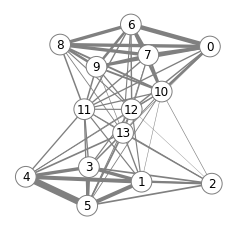

In [71]:
cs.draw_graph(
    J_events_norm, 
    node_pos=vp_node_pos_events, 
    node_size_factor=.2, 
    edge_width_factor=20, 
    labels='id', 
    figsize='small'
)

#### Projection to the person mode
Now set `how='facts'`.
##### Not using normalization

In [72]:
co_participations, person_attributes = cs.project_selection_matrix(
    selections=participations, 
    how='facts', 
    transaction_id='event_id', 
    fact_id='person_id', 
    norm=False
)

In the `co_participations` dataframe, `weight` tells how many events two persons had in common. `cumfrac` is a cumulative fraction which tells how much collective "attention" co-participations with at least that weight have generated:

In [73]:
co_participations.head()

,person_id_from,person_id_to,weight,cumfrac
0,4,9,6,0.1522
1,4,0,6,0.1522
2,9,16,6,0.1522
3,9,0,6,0.1522
4,16,0,6,0.1522


In [74]:
J_persons = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='J_persons', 
    node_list=person_attributes, 
    edge_list=co_participations
)

In [75]:
vp_node_pos_persons = nx.spring_layout(J_persons)

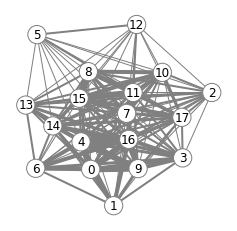

In [76]:
cs.draw_graph(
    J_persons, 
    node_pos=vp_node_pos_persons, 
    node_size_factor=.2, 
    labels='id', 
    figsize='small'
)

##### Using normalization

In [77]:
co_participations_norm, person_attributes_norm = cs.project_selection_matrix(
    selections=participations, 
    how='facts', 
    transaction_id='event_id', 
    fact_id='person_id', 
    norm=True
)

In the `person_attributes_norm` dataframe, the last three columns are scores that result from matrix multiplication. They are also described in the [meaning_structures](https://github.com/gesiscss/compsoc/blob/master/meaning_structures.ipynb) notebook of the `compsoc` toolkit. Roughly, `autocatalysis` tells to what extent a person contributes to events; `embeddedness` tells to what extent a person connects to others at events; `sociability` tells to what extent event participations lead to connections:

In [78]:
person_attributes_norm.head()

,person_id,degree,weight,autocatalysis,embeddedness,sociability
0,4,17,8.0,1.4881,0.8140,2.1250
1,9,15,7.0,1.2548,0.8207,2.1429
2,16,17,8.0,1.2548,0.8432,2.1250
3,0,15,7.0,1.1714,0.8327,2.1429
4,1,11,4.0,0.6417,0.8396,2.7500


In [79]:
J_persons_norm = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='J_persons_norm', 
    node_list=person_attributes_norm, 
    edge_list=co_participations_norm
)

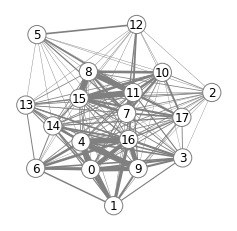

In [80]:
cs.draw_graph(
    J_persons_norm, 
    node_pos=vp_node_pos_persons, 
    node_size_factor=.2, 
    edge_width_factor=5, 
    labels='id', 
    figsize='small'
)